# ECON 31200 Part B Problem Set 3
#### Chase Abram, Tom Hierons, Jeanne Sorin


## Preliminary

In [22]:
### IMPORT PACKAGES
import numpy as np

import scipy.stats as st
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import binom

import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.integrate import simps

from sklearn.metrics import auc

import pandas as pd


## Defining Functions

### The DGP

In [29]:
### FUNCTIONS FOR THE DGP

def cov_f(conf=[1, 1, 1, 0, 0,0]):
    '''
    Function creating the covariance matrix for the different configurations
    Takes as default the identity matrix
    '''
    cov = [[conf[1], conf[3], conf[4]],
          [conf[3], conf[0], conf[5]],
          [conf[4], conf[5], conf[2]]]
    return(cov)

def errors_f(mean, cov, N):
    ''' This function generates multivariate join normal errors U1, U0, UC '''
    U1, U0, UC = np.random.multivariate_normal(mean, cov, N).T
    return(U1, U0, UC)

def Z_f(min, max, N):
    ''' This function generates Z ~ Unif[min, max] '''
    return(np.random.uniform(min, max, N))

def Y1_f(α, β, U1):
    ''' This function computes Y1 for a given vector U1 '''
    return(α + β + U1)

def Y0_f(α, U0):
    ''' This function computes Y0 for a given vector U0 '''
    return(α + U0)

def C_f(Z, UC):
    ''' This function computes C for given vectors Z and UC (independent)'''
    return(Z + UC)

def D_f(Y1, Y0, C):
    ''' This function computes the choice function D, given vectors Y1, Y0 and C '''
    D = np.zeros(len(Y0))
    for i in range(len(Y0)):
        if Y1[i] - Y0[i] - C[i] >= 0: 
            D[i] = 1
    return(D)

def muD_f(β, Z):
    ''' This function computes μD(Z) '''
    return(β + Z)
    
def pZ_f(β, σ, Z):
    return([norm.cdf((β-z)/σ) for z in Z])


### A function to generate data in one clic

In [3]:
def DGP_f(N, α, β, min, max, mean, conf, minmax2=False, min2 = 0, max2 = 0):
    ''' This function generates the data "in one clic" '''
    
    cov = cov_f(conf)
    U1, U0, UC = errors_f(mean, cov, N)
    Y1 = Y1_f(α, β, U1)
    Y0 = Y0_f(α, U0)
    
    if minmax2 == False:
        Z = Z_f(min, max, N)
    if minmax2 == True:
        '''
        Relevant for 3.C. 
        Bonus: allow interval to have different lenght because why not'''
        Z1 = Z_f(min, max, N)
        Z2 = Z_f(min2, max2, N)
        p = (max - min)/(max - min + max2 - min2)
        pick = binom.rvs(1, 0.5, size=N)
        Z = Z1*pick + Z2*(1-pick)
 
    C = C_f(Z, UC)
    D = D_f(Y1, Y0, C)
    μD = muD_f(β, Z)
    return(Y1, Y0, Z, C, D, cov, μD, U1, U0, UC)

### The Econometrics : $U_D$, the $MTE$, the $LIV$

#### $U_D$
All treatment effects are both estimated for a given $U_D = \Phi(\frac{V}{\sigma_V})$, where $V = U_0 + U_C - U_1$.

We need to compute $\sigma_V$

\begin{align*}
\sigma_V^2 &= Var(U_0 + U_C - U_1) \\
&= Var(U_0) + Var(U_1) + Var(U_C) +  2 Cov(U_0, U_C) - 2 Cov(U_0, U_1) - 2 Cov(U_C, U_1) \\
&= \sigma_0^2 + \sigma_1^2 + \sigma_c^2 + 2 \sigma_{0C} - 2 \sigma_{01} - 2 \sigma_{1C} \\
\sigma_V &= \sqrt{\sigma_0^2 + \sigma_1^2 + \sigma_c^2 + 2 \sigma_{0C} - 2 \sigma_{01} - 2 \sigma_{1C}}
\end{align*}

In [4]:
# Compute Ud
def Ud_f(U1, U0, UC, cov):
    ''' This function computes U_D for a given vector of errors, and covariance structure '''
    σ0_2 = cov[0][0]
    σ1_2 = cov[1][1]
    σc_2 = cov[2][2]
    σ01 = cov[0][1]
    σ0c = cov[0][2]
    σ1c = cov[1][2]
    # σv
    σv = np.sqrt(σ0_2 + σ1_2 + σc_2 + 2*σ0c - 2*σ1c - 2*σ01)
    # V
    V = U0 + UC - U1
    # Ud = Φ(V/σv)
    Ud = norm.cdf(V/σv)
    return(Ud, σv)

#### The MTE

The MTE for the generalized Roy model is defined the following way:
\begin{align*}
    MTE(u_d) = E(Y_1 - Y_0 | U_d = u_d) &= E(\alpha + \beta + U_1 - (\alpha + U_0) | V = v, Z=z) \\
    &= \beta + E(U_1 - U_0 | U_d = u_d) \\
    &= \beta + E(U_1 - U_0 | \Phi(\frac{U_0 + U_C - U_1}{\sigma_v}) = u_d) \\
    &= \beta + E(U_1 - U_0 | \Phi(\frac{V}{\sigma_v}) = u_d) \\
    &= \beta + E(U_1 - U_0 | \frac{V}{\sigma_v} = \Phi^{-1}(u_d)) \\
    &= \beta + Cov(U_1 - U_0, \frac{V}{\sigma_v}) \Phi^{-1}(u_d)
\end{align*}
Where the last line follows from the conditional expectation formula with normally distributed RV in the conditioning.

At that point we need to compute
\begin{align*}
Cov(U_1 - U_0, \frac{V}{\sigma_v}) &= Cov(U_1 - U_0, \frac{U_0 + U_C - U_1}{\sigma_v}) \\
&= Cov(U_1 - U_0, \frac{U_1 - U_0}{- \sigma_V}) + Cov(U_1 - U_0, \frac{U_C}{\sigma_V}) \\
&= - \frac{1}{\sigma_V}V(U_1 - U_0) + \frac{1}{\sigma_V} Cov(U_1 - U_0, U_C) \\
&= \frac{-\sigma_0^2 - \sigma_1^2 + 2\sigma_{01} + \sigma_{1C} - \sigma_{0C}}{\sqrt{\sigma_0^2 + \sigma_C^2 + \sigma_1^2 + 2 \sigma_{0,C} - 2 \sigma_{0,1} - 2 \sigma_{1,C}}}
\end{align*}


Therefore we have
\begin{align*}
    MTE(u_d) = E(Y_1 - Y_0 | U_d = u_d) &= E(\alpha + \beta + U_1 - (\alpha + U_0) | V = v, Z=z) \\
    &= \beta + \frac{-\sigma_0^2 - \sigma_1^2 + 2\sigma_{01} + \sigma_{1C} - \sigma_{0C}}{\sqrt{\sigma_0^2 + \sigma_C^2 + \sigma_1^2 + 2 \sigma_{0,C} - 2 \sigma_{0,1} - 2 \sigma_{1,C}}} \Phi^{-1}(u_d)
\end{align*}

In [5]:
# Compute the MTE for a given Ud & Graph it
def MTE_f(β, cov, plot=True):
    '''
    This function computes the MTE for a given Ud (or vector)
    MTE = β + Cov(U_1 - U_0, \frac{V}{\sigma_V})Φ^{-1}(Ud)
    '''
    # Extract covariances to make it easier to read
    σ0_2, σ1_2, σc_2, σ01, σ0c, σ1c = cov[0][0], cov[1][1], cov[2][2], cov[0][1], cov[0][2], cov[1][2]
    
    # σv
    σv = np.sqrt(σ0_2 + σ1_2 + σc_2 + 2*σ0c - 2*σ1c - 2*σ01)
    
    # Cov(U_1 - U_0, V/σv)
    Cov_int = 1/σv *(- σ1_2 - σ0_2 + 2*σ01 + σ1c - σ0c)
    
    # Ud is a theory object here!
    Ud = np.linspace(0, 1, N)
    
    # \Phi^{-1}(Ud)
    v = norm.ppf(Ud)
    
    MTE = β + Cov_int*v
    
    if plot==True:
        plt.plot(Ud, MTE, linewidth=2, alpha=0.6, label='MTE')
        plt.show()
        
    return(MTE)

### The LIV

We have that
\begin{align*}
    MTE(u_d) = E(Y_1 - Y_0 | U_d = u_d) &= E(\alpha + \beta + U_1 - (\alpha + U_0) | V = v, Z=z) \\
    &= \beta + \frac{-\sigma_0^2 - \sigma_1^2 + 2\sigma_{01} + \sigma_{1C} - \sigma_{0C}}{\sqrt{\sigma_0^2 + \sigma_C^2 + \sigma_1^2 + 2 \sigma_{0,C} - 2 \sigma_{0,1} - 2 \sigma_{1,C}}} \Phi^{-1}(u_d) \\
    &= \beta + \frac{\gamma}{\sigma_V} \Phi^{-1}(u_d)
\end{align*}
With $\gamma = -\sigma_0^2 - \sigma_1^2 + 2\sigma_{01} + \sigma_{1C} - \sigma_{0C}$ and $\sigma_V = \sqrt{\sigma_0^2 + \sigma_C^2 + \sigma_1^2 + 2 \sigma_{0,C} - 2 \sigma_{0,1} - 2 \sigma_{1,C}}$

To get the LIV, which is the sample equivalent of the MTE, replace $U_d$ by $p$
\begin{align*}
LIV(p) &= \beta + \frac{\gamma}{\sigma_V} \Phi^{-1}(p)
\end{align*}

In [6]:
# For each configuration, compute the LIV

def LIV_f(Z_values, α, β, cov, return_v=True):
    ''' 
    For each configuration, compute the LIV
    '''
    # Extract variance
    σ0_2, σ1_2, σc_2, σ01, σ0c, σ1c = cov[0][0], cov[1][1], cov[2][2], cov[0][1], cov[0][2], cov[1][2]

    # parameters to evaluate
    γ0 = σ0_2 + σ0c - σ01
    γ1 = σ01 + σ1c - σ1_2
    σ = np.sqrt(σ1_2 + σ0_2 + σc_2 - 2*(σ01 + σ1c - σ0c))
    
    # Propensity score over the domain of Z
    p = [norm.cdf((β - z)/σ) for z in Z_values]
    LIV = [β + ((γ1 - γ0)/σ)*norm.ppf(u) for u in p]
    
    if return_v==True:
        return(LIV, p)


In [7]:
def plot_LIV_MTE(N, α, β, cov, Z_config, confi_nb ="I", Z_title="Z ~ U[-0.5, 0.5]"):
    
    # Get Z
    if len(Z_config)==2:
        Z = Z_f(Z_config[0], Z_config[1], N)
    if len(Z_config)==4:
        '''
        Relevant for 3.C. 
        Bonus: allow interval to have different lenght because why not
        '''
        min, max, min2, max2 = Z_config[0], Z_config[1], Z_config[2], Z_config[3]
        Z1 = Z_f(min, max, N)
        Z2 = Z_f(min2, max2, N)
        p = (max - min)/(max - min + max2 - min2)
        pick = binom.rvs(1, 0.5, size=N)
        Z = Z1*pick + Z2*(1-pick)

        
        
    mte = MTE_f(β, cov, plot=False)
    liv = LIV_f(Z, α, β, cov)
    
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0, 1, N), mte, linewidth=2, alpha=0.4, label='MTE')
    ax.scatter(liv[1], liv[0],c='pink', alpha=0.4, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Comparison of MTE and LIV for configuration ' + str(confi_nb) + ' With ' + str(Z_title))
    plt.show()

### Objective vs Subjective Treatment Effects

The objective treatment is given by
\begin{align*}
Y_1 - Y_0 &= \beta + U_1 - U_0 \sim N(\beta, \sigma_0^2 + \sigma_1^2 - 2 \sigma_{01}) \\
\end{align*}
The subjective treatment is given by
\begin{align*}
Y_1 - Y_0 - C | Z &= \beta - Z + U_1 - U_0 - U_C \sim N(\beta  - Z, \sigma_0^2 + \sigma_1^2 + \sigma_c^2 - 2 (\sigma_{01} + \sigma_{1c} - \sigma_{0c} \\
\end{align*}

In [8]:
def treat_effect_f(β, cov, plot=True, ret=False):
    
    σ0_2, σ1_2, σc_2, σ01, σ0c, σ1c = cov[0][0], cov[1][1], cov[2][2], cov[0][1], cov[0][2], cov[1][2]

    # parameters to evaluate
    σ_obj = (σ0_2 + σ1_2 - 2*σ01)**0.5
    σ_subj = (σ1_2 + σ0_2 + σc_2 -2*(σ01 + σ1c - σ0c))**0.5
    
    # Compute treatment effects and pdf
    obj = [β + i*σ_obj for i in np.linspace(-2, 2,10000)]
    obj_pdf = [norm.pdf(TE, β, σ_obj) for TE in obj]
    
    subj = [β + i*σ_subj for i in np.linspace(-2, 2,10000)]
    subj_pdf = [norm.pdf(TE, β, σ_subj) for TE in subj]
    
    if plot==True: 
        print("Configuration ", i+1)
        fig, ax = plt.subplots()
        ax.plot(obj, obj_pdf, linewidth=2, alpha=0.4, label='Obj')
        ax.plot(subj, subj_pdf,c='red', alpha=0.4, label='Subj')
        ax.legend(loc='best')
        ax.set_title('Objective vs Subjective Treatment Effects evaluated at Z =0')
        ax.set_xlabel('$u_D$')
        plt.show()
    
    if ret==True:
        return obj, obj_pdf, subj, subj_pdf


### Weights : MTE the generator

See pdf file for derivations

In [96]:
def weight_f(β, minZ, maxZ, minZ_prime, maxZ_prime, N, conf = [1, 1, 1, 0, 0, 0]):
    
    cov = cov_f(conf)
    σ0_2, σ1_2, σc_2, σ01, σ0c, σ1c = cov[0][0], cov[1][1], cov[2][2], cov[0][1], cov[0][2], cov[1][2]
    Ud = np.linspace(0, 1, N)
    MTE = MTE_f(β, cov, plot=False)
    
    γ0 = σ0_2 + σ0c - σ01
    γ1 = σ01 + σ1c - σ1_2
    σ = (σ1_2 + σ0_2 + σc_2 - 2*(σ01 + σ1c - σ0c))**0.5
    
    # Z & propensity score for the main policy and an alternative policy
    Z = Z_f(minZ, maxZ, N)
    pZ = pZ_f(β, σ, Z)
    Z_prime = Z_f(minZ_prime, maxZ_prime, N)
    pZ_prime = pZ_f(β, σ, Z_prime)
    pmean = np.mean(pZ)
    pvar = np.var(pZ)
    
    #CDF of Ud
    F = lambda u : len([p for p in pZ if p <= u])/len(pZ)
    #CDF of Ud under alternative policy
    F_alt = lambda u : len([p for p in pZ_prime if p <= u])/len(pZ_prime)

    #ATE
    w_ATE = np.ones(N)
    
    #TT
    w_TT = [(1-F(u))/pmean for u in Ud]
    
    #TUT
    w_TUT = [F(u)/(1-pmean) for u in Ud]
    
    #OLS
    w_OLS = [1+ (2*norm.ppf(Ud[i]))/(MTE[i]*σ)*(γ1*w_TT[i]+γ0*w_TUT[i]) for i in range(len(Ud))]
    
    #PRTE
    w_PRTE = [F_alt(u) - F(u) for u in Ud]
    
    # IV
    w_IV = np.nan_to_num([(np.mean([p for p in pZ if p >= u]) - pmean)*(pmean/pvar) for u in Ud])

    
    return(w_ATE, w_TT, w_TUT, w_OLS, w_IV, w_PRTE, Ud, MTE)

def graph_weights1(configurations, minZ, maxZ, minZ_prime, maxZ_prime, N, i=1):
    w_ATE, w_TT, w_TUT, w_OLS, w_IV, w_PRTE, Ud, MTE = weight_f(β, minZ, maxZ, minZ_prime, maxZ_prime, N, conf = configurations[i])

    fig, ax = plt.subplots()
    ax.plot(Ud, MTE, linewidth=2, alpha=0.6, label='MTE')
    ax.plot(Ud, w_ATE, linestyle='dashed', linewidth=2, alpha=0.4, color="pink", label='$w_{ATE}$')
    ax.plot(Ud, w_TT, linestyle='dashed', linewidth=2, alpha=0.4, color="blue", label='$w_{TT}$')
    ax.plot(Ud, w_TUT, linestyle='dashed', linewidth=2, alpha=0.4, color="green", label='$w_{TUT}$')
    ax.legend(loc='best')
    ax.set_title('Beautiful graph of MTE and weights (1)')
    ax.set_xlabel('$u_d$')
    plt.show()
    print("ATE = ", np.round(np.dot(MTE[1:len(MTE)-1], w_ATE[1:len(w_ATE)-1])/N, 3))
    print("TT = ", np.round(np.dot(MTE[1:len(MTE)-1], w_TT[1:len(w_TT)-1])/N, 3))
    print("TUT = ", np.round(np.dot(MTE[1:len(MTE)-1], w_TUT[1:len(w_TUT)-1])/N, 3))

    
    # scale
    w_OLS = [min(w_OLS[i], 20) for i in range(len(w_OLS))]
    w_OLS = [max(w_OLS[i], -20) for i in range(len(w_OLS))]
    fig, ax2 = plt.subplots()
    ax2.plot(Ud, MTE, linewidth=2, alpha=0.6, label='MTE')
    ax2.plot(Ud, w_OLS, linestyle='dashed', linewidth=2, alpha=0.4, color="pink", label='$w_{OLS}$')
    ax2.plot(Ud, w_IV, linestyle='dashed', linewidth=2, alpha=0.4, color="blue", label='$w_{IV}$')
    ax2.plot(Ud, w_PRTE, linestyle='dashed', linewidth=2, alpha=0.4, color="green", label='$w_{PRTE}$')
    ax2.legend(loc='best')
    ax2.set_title('Beautiful graph of MTE and weights (2)')
    ax2.set_xlabel('$u_d$')
    plt.show()  
    print("OLS = ", np.round(np.dot(MTE[1:len(MTE)-1], w_OLS[1:len(w_OLS)-1])/N, 3))
    print("IV = ", np.round(np.dot(MTE[1:len(MTE)-1], w_IV[1:len(w_IV)-1])/N, 3))
    print("PRTE = ", np.round(np.dot(MTE[1:len(MTE)-1], w_PRTE[1:len(w_PRTE)-1])/N, 3))

    fig, ax3 = plt.subplots()
    ax3.plot(Ud, MTE, linewidth=2, alpha=0.6, label='MTE')
    ax3.plot(Ud, w_PRTE, linestyle='dashed', linewidth=2, alpha=0.4, color="green", label='$w_{PRTE}$')
    ax3.legend(loc='best')
    ax3.set_title('Beautiful graph of MTE and PRTE weights (2)')
    ax3.set_xlabel('$u_d$')
    plt.show()  
    

## Let's do it!

### Preliminary : set up the problem

In [38]:
### Set parameters
N = 1000
α = 0.67
β = 0.2
mean = [0, 0, 0]

In [39]:
### Different var-cov configurations
conf1 = [1, 1, 1, 0, 0, 0]
conf2 = [1, 1, 1, 0.5, -0.5, 0]
conf3 = [1, 1, 1, 0, 0, 0.5]
conf4 = [1, 1, 0, 0.5, 0, 0]
conf5 = [1, 0.25, 1, 0.1, -0.2, 0.2]
conf6 = [0.25, 0.25, 1, -0.2, 0.1, -0.2]
conf7 = [1, 1, 1, -0.2, 0.6, 0.5]

configurations = (conf1, conf2, conf3, conf4, conf5, conf6, conf7)

In [40]:
### Different configurations for the instrument
minmax_baseline = [-0.5, 0.5]
minmax_A = [-0.1, 0.1]
minmax_B = [0, 0]
minmax_C = [-0.5, -0.3, 0.3, 0.5]

In [41]:
### Generate data
Y1, Y0, Z, C, D, cov, μD, U1, U0, UC = DGP_f(N, α, β, 
                                             minmax_baseline[0], minmax_baseline[1], 
                                             mean, conf1, minmax2=False, min2 = 0, max2 = 0)
UD, σv = Ud_f(U1, U0, UC, cov)

### B) C) The MTE and LIV for each error configuration


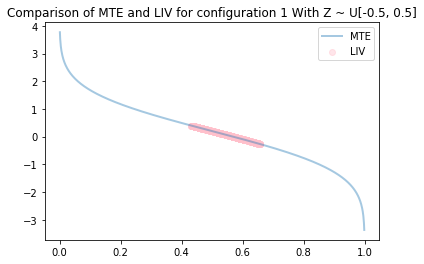

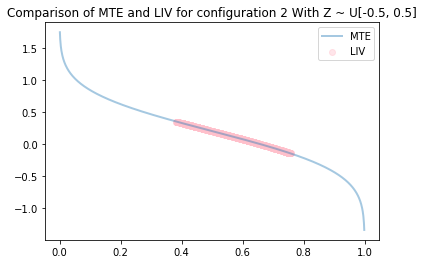

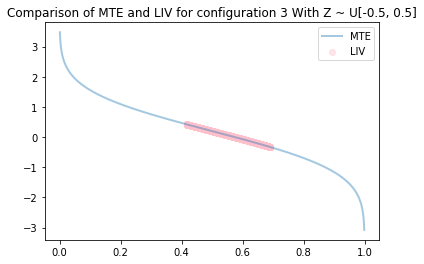

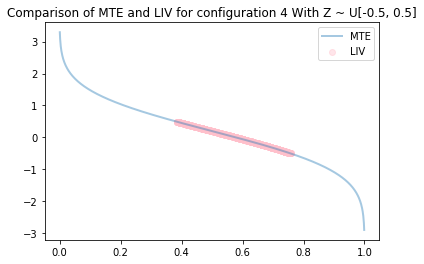

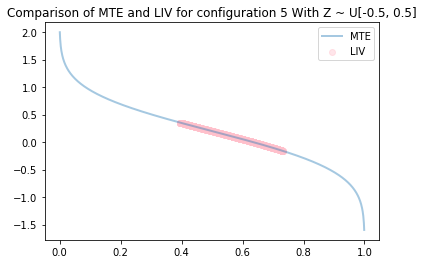

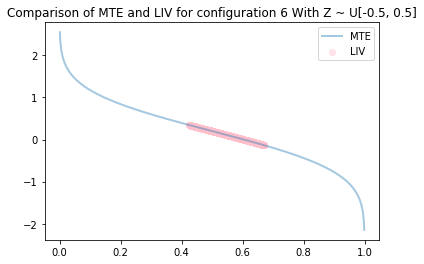

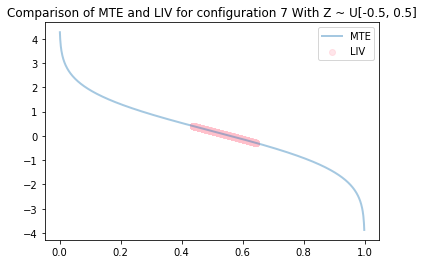

In [14]:
for i in range((len(configurations))):
    plot_LIV_MTE(N, α, β, cov_f(configurations[i]), minmax_baseline, confi_nb =i+1, Z_title="Z ~ U[-0.5, 0.5]")
  

### C) The objective and subjective treatment effects

Configuration  1


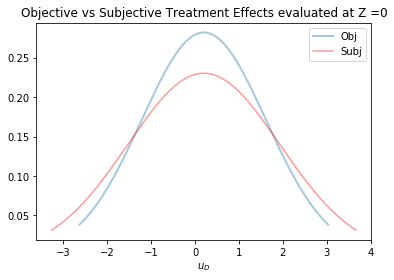

Configuration  2


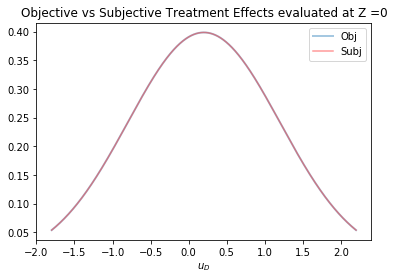

Configuration  3


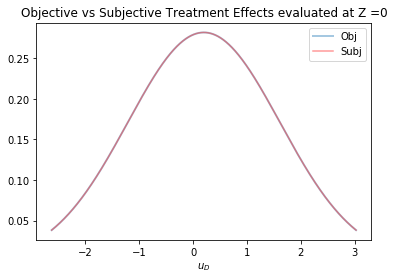

Configuration  4


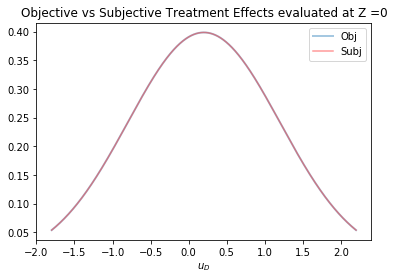

Configuration  5


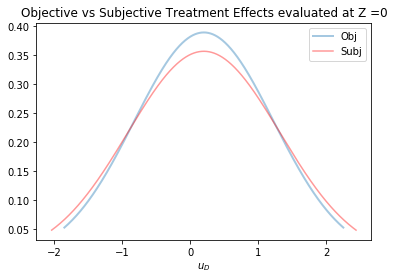

Configuration  6


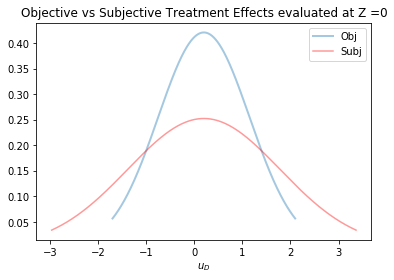

Configuration  7


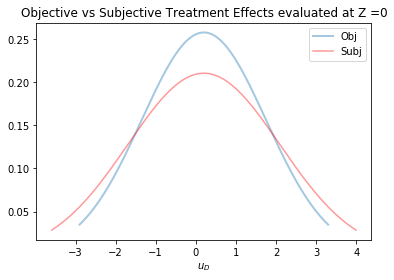

In [15]:
for i in range((len(configurations))):
    treat_effect_f(β, cov_f(configurations[i]))

### D) The weights 

Configuration  1


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


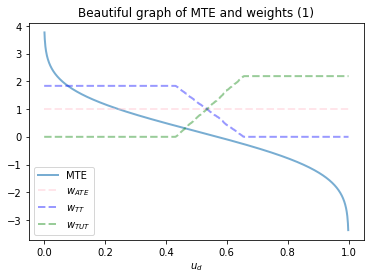

ATE =  0.2
TT =  1.026
TUT =  -0.785


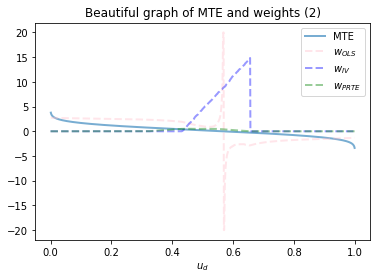

OLS =  2.01
IV =  -0.066
PRTE =  0.026


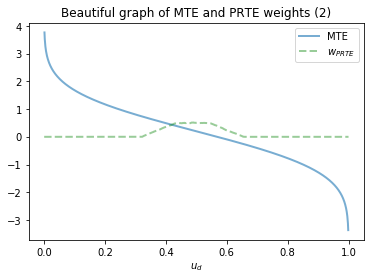

Configuration  2


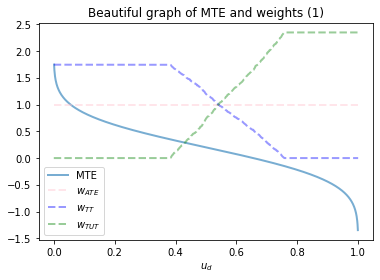

ATE =  0.2
TT =  0.526
TUT =  -0.239


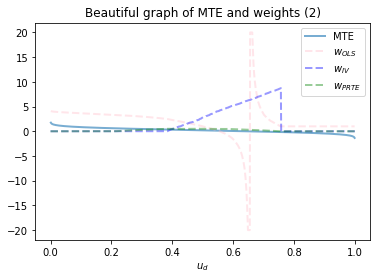

OLS =  0.854
IV =  0.045
PRTE =  0.042


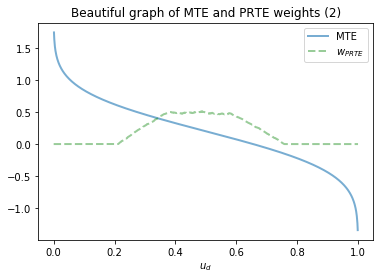

Configuration  3


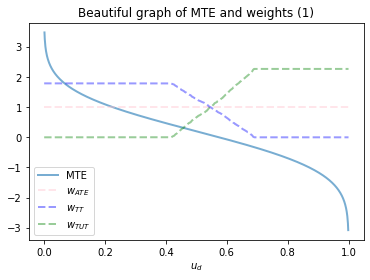

ATE =  0.2
TT =  0.929
TUT =  -0.725


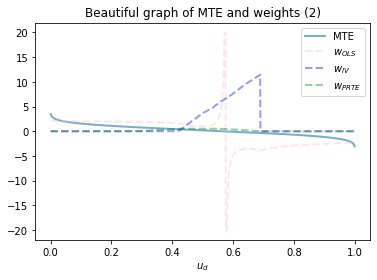

OLS =  1.917
IV =  -0.106
PRTE =  0.033


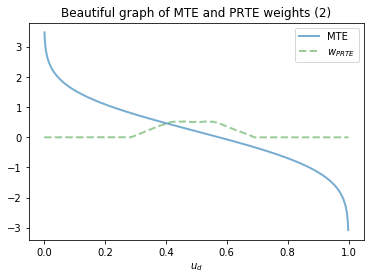

Configuration  4


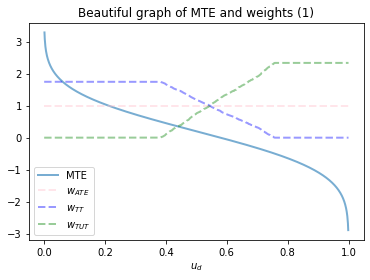

ATE =  0.2
TT =  0.854
TUT =  -0.676


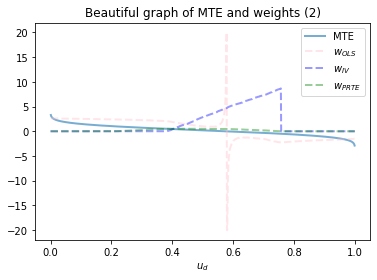

OLS =  1.729
IV =  -0.237
PRTE =  0.047


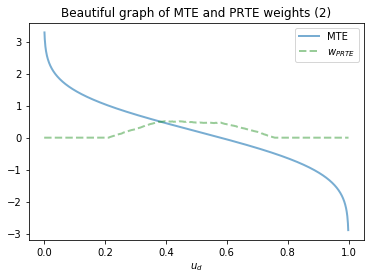

Configuration  5


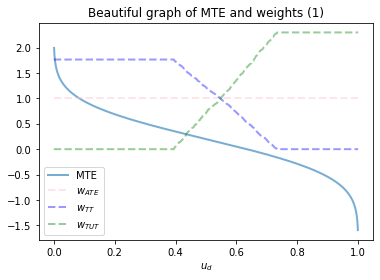

ATE =  0.2
TT =  0.589
TUT =  -0.308


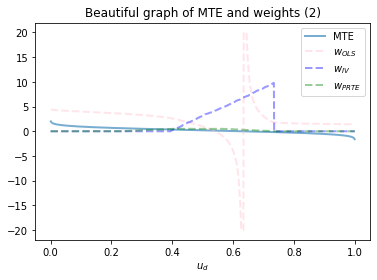

OLS =  0.963
IV =  0.031
PRTE =  0.038


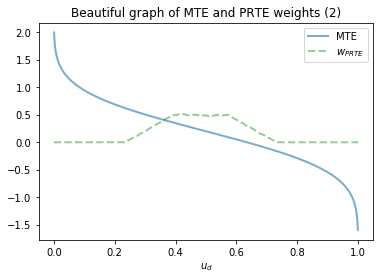

Configuration  6


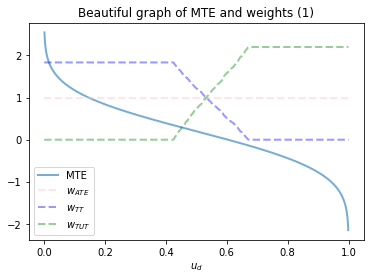

ATE =  0.2
TT =  0.739
TUT =  -0.447


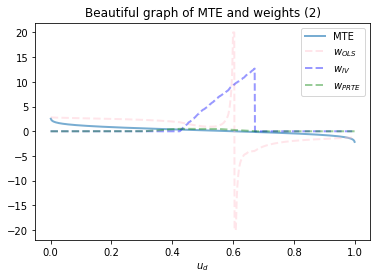

OLS =  1.375
IV =  0.051
PRTE =  0.027


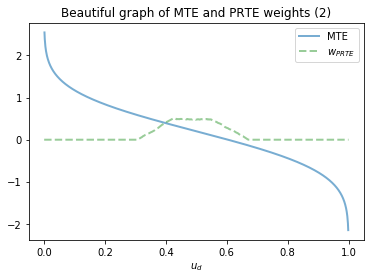

Configuration  7


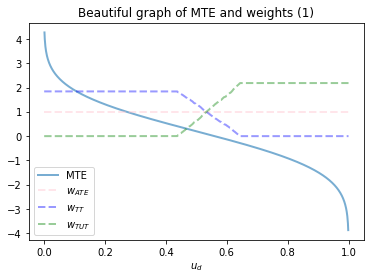

ATE =  0.2
TT =  1.146
TUT =  -0.924


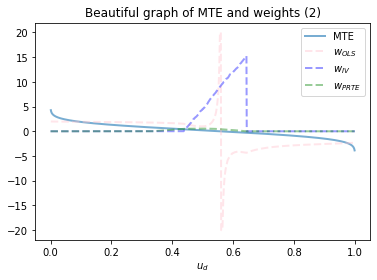

OLS =  2.346
IV =  -0.082
PRTE =  0.025


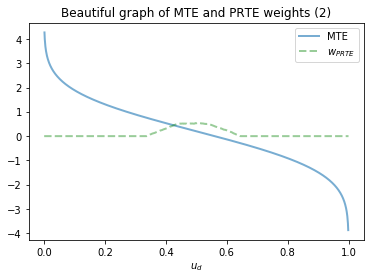

In [98]:
for i in range((len(configurations))):
    print("Configuration ", i+1)
    graph_weights1(configurations, minZ=minmax_baseline[0], maxZ=minmax_baseline[1],
                  minZ_prime=0, maxZ_prime=1, N=N, i=i)
    
    

### E) Which estimators and parameters depend on normality? Show how to relax the normality assumption. Which ones do not?

See pdf document.

## Question 3 - The impact of instrument Configuration

### A) Z ∼ Unif[-0.1, 0.1]

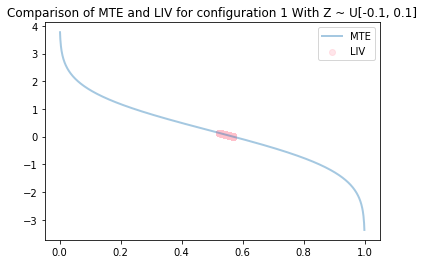

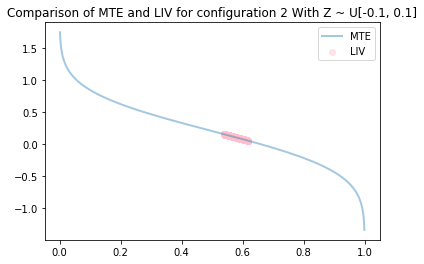

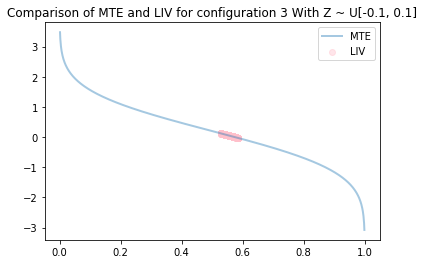

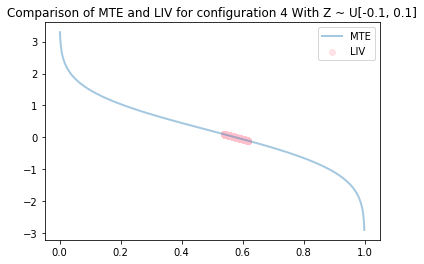

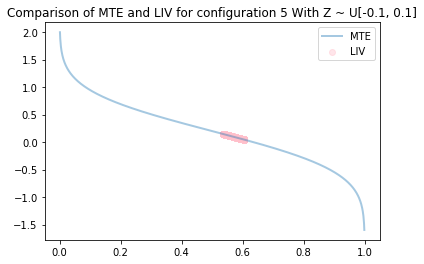

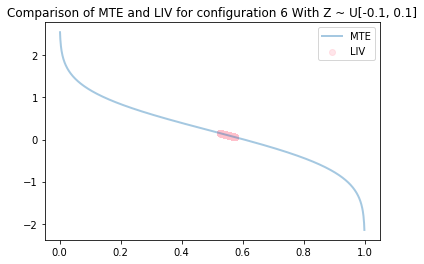

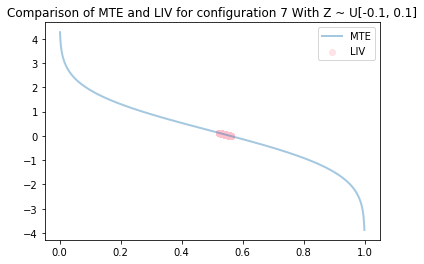

In [17]:
for i in range((len(configurations))):
    plot_LIV_MTE(N, α, β, cov_f(configurations[i]), minmax_A, confi_nb =i+1, Z_title="Z ~ U[-0.1, 0.1]")

### B) Z∼Unif[0,0]



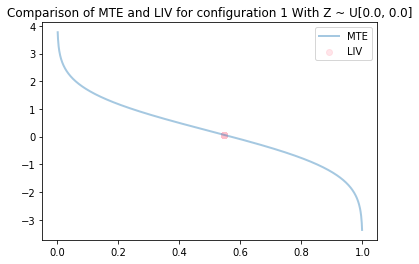

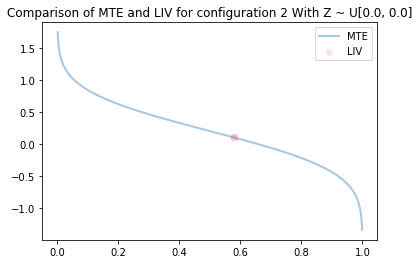

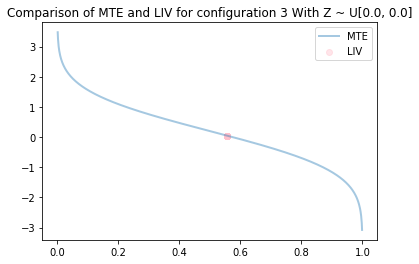

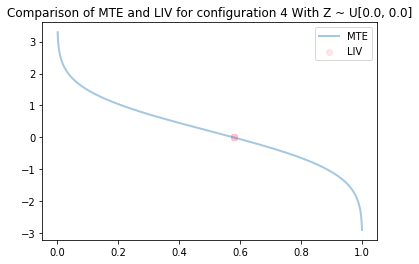

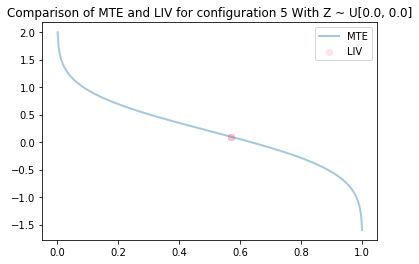

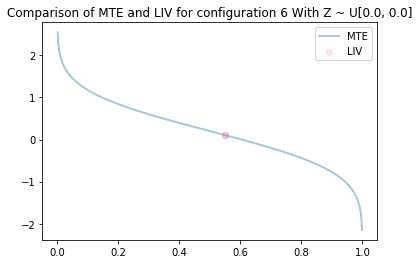

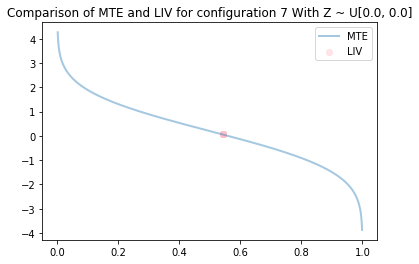

In [18]:
for i in range((len(configurations))):
    plot_LIV_MTE(N, α, β, cov_f(configurations[i]), minmax_B, confi_nb =i+1, Z_title="Z ~ U[0.0, 0.0]")

### C) Z∼Unif[−0.5,−0.3]∪Unif[0.3,0.5].

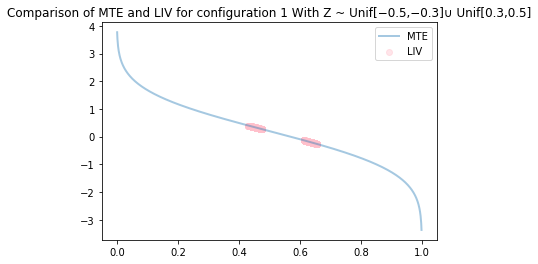

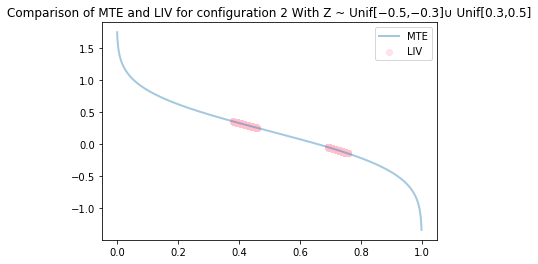

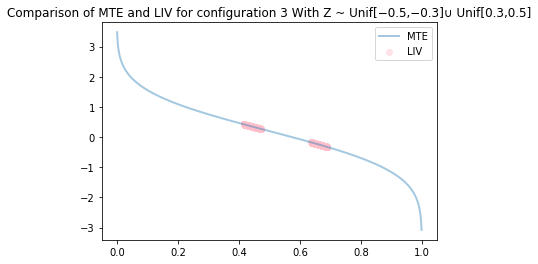

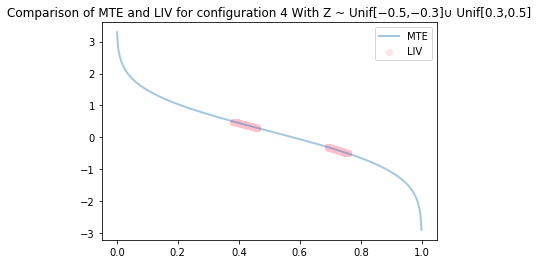

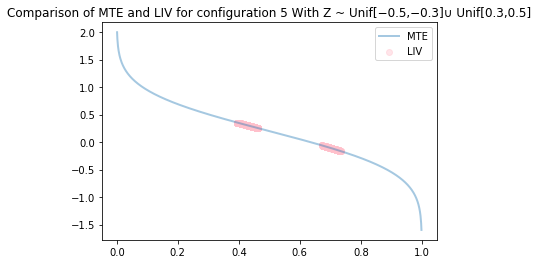

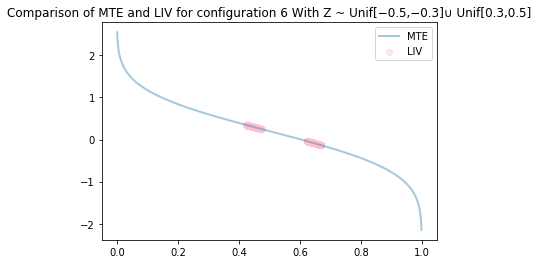

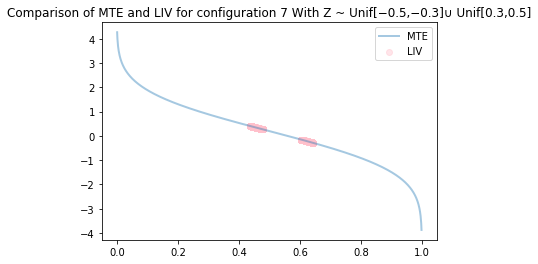

In [19]:
for i in range((len(configurations))):
    plot_LIV_MTE(N, α, β, cov_f(configurations[i]), minmax_C, confi_nb =i+1, Z_title="Z ~ Unif[−0.5,−0.3]∪ Unif[0.3,0.5]")

## Question 7 - The impact of instrument Configuration

In [23]:
def noisy_vars(U0,U1,UC,Z,conf):
    '''Creates noisy versions of the random variables given the configuration'''
    U0t = U0 + np.random.normal(0,conf[0],len(U0))
    U1t = U1 + np.random.normal(0,conf[1],len(U1))
    Vt = U0 + UC - U1 + np.random.normal(0,conf[2],len(U1))
    Zt = Z + np.random.normal(0,conf[3],len(U1))
    return(U0t, U1t, Vt, Zt)

In [24]:
confi = [1,2,1,.5]
confii = [1,0,2,1]
confiii = [.05,.1,.01,.1]
n_configurations = [confi, confii, confiii]

We now compute the ATE, ATT, ATUT, Linear IV and OLS for each of the $7\times 3$ possible parameter configurations:

In [26]:
results = pd.DataFrame(columns = ["config","ATE-ex-ante", "ATE-ex-post", 
                                  "ATT-ex-ante", "ATT-ex-post", 
                                  "ATUT-ex-ante", "ATUT-ex-post"])
print(pd.DataFrame.head(results))

Empty DataFrame
Columns: [config, ATE-ex-ante, ATE-ex-post, ATT-ex-ante, ATT-ex-post, ATUT-ex-ante, ATUT-ex-post]
Index: []


In [27]:
# Initialise data frame to store the parameters

# Loop through all the configurations to give the desired estimates
r = 0
for c in configurations:
    for ct in n_configurations:
        Y1, Y0, Z, C, D, cov, μD, U1, U0, UC = DGP_f(10**5, α, β, 0, 1,mean, c, minmax2=False, min2 = 0, max2 = 0)
        U0t, U1t, Vt, Zt = noisy_vars(U0,U1,UC,Z,ct)
        Y0t, Y1t = Y0_f(α, U0t), Y1_f(α,β,U1t)
        df = pd.DataFrame( list(zip(Y1, Y0, Z, C, D, U1, U0, UC,U0t, U1t, Vt, Zt,Y0t, Y1t)), 
                     columns = ["Y1", "Y0", "Z", "C", "D", "U1", "U0", "UC","U0t", "U1t", "Vt", "Zt","Y0t","Y1t"])
        results.loc[r, "config"]= [c,ct]
        results.loc[r, "ATE-ex-ante"]= round(np.mean(Y1-Y0),3)
        results.loc[r, "ATE-ex-post"]= round(np.mean(Y1t-Y0t),3)
        results.loc[r, "ATT-ex-ante"] = round(np.mean(df[D==1].Y1 - df[D==1].Y0),3)
        results.loc[r, "ATT-ex-post"] = round(np.mean(df[D==1].Y1t - df[D==1].Y0t),3)
        results.loc[r, "ATUT-ex-ante"] = round(np.mean(df[D==0].Y1 - df[D==0].Y0),3)
        results.loc[r, "ATUT-ex-post"] = round(np.mean(df[D==0].Y1t - df[D==0].Y0t),3)
        r+=1
print("finished")

finished


In [28]:
pd.DataFrame.to_csv(results,"results.csv")